2025-09-04 16:26:51.105667: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757003211.479959      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757003211.584040      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow Version: 2.18.0
Num GPUs Available:  2

Class names found: ['Bengin cases', 'Malignant cases', 'Normal cases']

Training data distribution:
{'Bengin cases': 120, 'Malignant cases': 561, 'Normal cases': 416}

Displaying one sample image from each class...


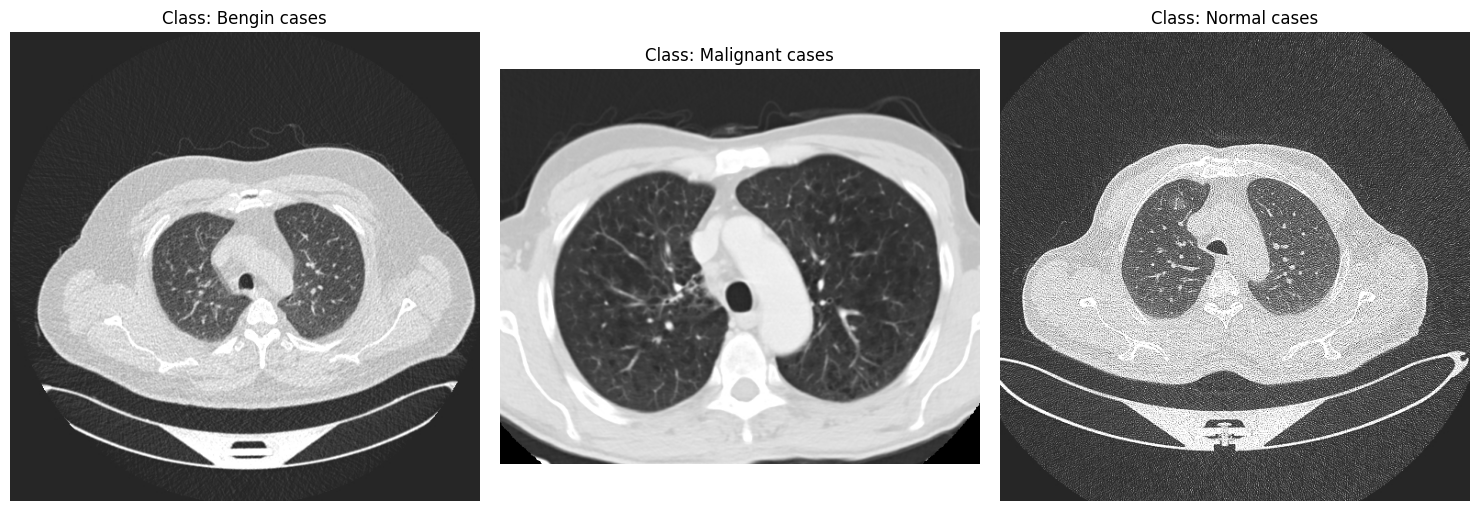

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# --- 1. Confirm GPU is Active ---
print("TensorFlow Version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


# --- 2. Define Corrected Paths and Explore Data ---
base_path = '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset'
data_dir = os.path.join(base_path, 'The IQ-OTHNCCD lung cancer dataset')

# Get the class names by looking ONLY for directories inside the data_dir
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print(f"\nClass names found: {class_names}")

# Count the number of images in each class
class_distribution = {c: len(os.listdir(os.path.join(data_dir, c))) for c in class_names}
print("\nTraining data distribution:")
print(class_distribution)


# --- 3. Display Sample Images from Each Class ---
print("\nDisplaying one sample image from each class...")
plt.figure(figsize=(15, 5))
for i, class_name in enumerate(class_names):
    # Get a list of all image files in the class directory
    image_files = os.listdir(os.path.join(data_dir, class_name))
    # Pick one random image to display
    sample_image_name = np.random.choice(image_files)
    sample_image_path = os.path.join(data_dir, class_name, sample_image_name)
    
    # Load and display the image
    img = Image.open(sample_image_path)
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# --- 1. Define Constants and Prepare Data Pipeline ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
# The 'data_dir' variable was correctly defined in the previous cell.

# Create the training dataset from the image folders
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical', # Multi-class classification
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

# Create the validation dataset from the same image folders
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

# A layer for subtle data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Prefetch data for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


# --- 2. Build the Model using Transfer Learning ---
# Load the MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the pre-trained layers
base_model.trainable = False

# Create our new custom model on top
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
# Final classification layer with 3 units (for 3 classes) and softmax activation
outputs = layers.Dense(3, activation='softmax')(x) 
model = keras.Model(inputs, outputs)


# --- 3. Compile the Model ---
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print a summary of our model's architecture
print("\nModel built and compiled successfully.")
model.summary()

Found 1097 files belonging to 3 classes.
Using 878 files for training.


I0000 00:00:1757003233.637335      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757003233.638002      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1097 files belonging to 3 classes.
Using 219 files for validation.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Model built and compiled successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10


I0000 00:00:1757003246.009136      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.5103 - loss: 1.0856 - val_accuracy: 0.8219 - val_loss: 0.5160
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.7993 - loss: 0.5166 - val_accuracy: 0.8447 - val_loss: 0.4424
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8215 - loss: 0.4467 - val_accuracy: 0.8676 - val_loss: 0.4083
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.8599 - loss: 0.3443 - val_accuracy: 0.8676 - val_loss: 0.4120
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8270 - loss: 0.3734 - val_accuracy: 0.8767 - val_loss: 0.3707
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.8683 - loss: 0.3141 - val_accuracy: 0.8630 - val_loss: 0.3803
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.8748 - loss: 0.3425 - val_accuracy: 0.8813 - val_loss: 0.3336
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8704 - loss: 0.3127 - val_accuracy: 0.8630 - val_loss: 

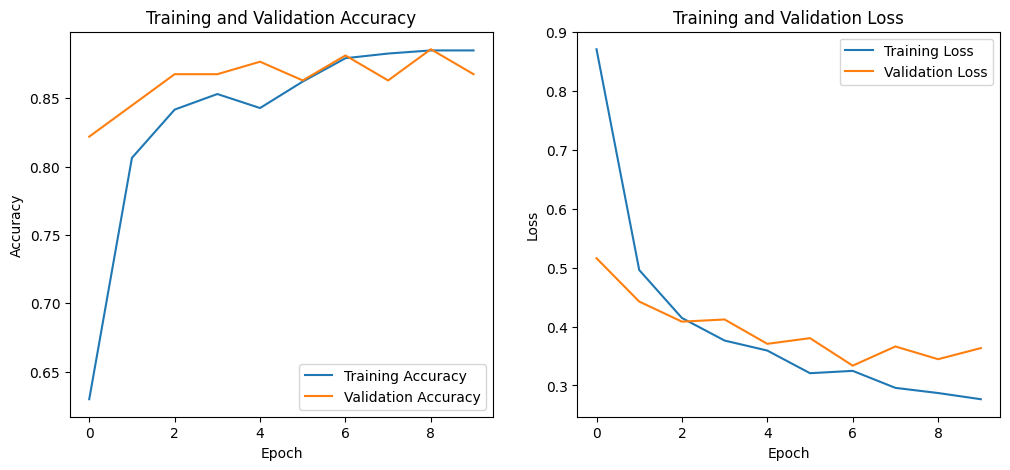


Final module complete. Model saved successfully as 'lung_cancer_model.keras'


In [3]:
# --- 1. Train the Model ---
# We'll train for 10 epochs to ensure the model learns the features well.
epochs = 10
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset
)

# --- 2. Visualize Training Results ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()


# --- 3. Save the Final Model ---
filename = 'lung_cancer_model.keras'
model.save(filename)
print(f"\nFinal module complete. Model saved successfully as '{filename}'")